In [ ]:
!pip install optuna
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error
import joblib
from datetime import datetime
from google.colab import drive
import os
import optuna

# ==============================================================================
# COLAB-SPECIFIC SETUP
# ==============================================================================
print("--- Setting up for Google Colab ---")

# Install LightGBM and Optuna for hyperparameter tuning
!pip install lightgbm optuna -q
print("✅ LightGBM and Optuna are installed.")

# Mount your Google Drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully.")

# --- DEFINE YOUR FILE PATHS IN GOOGLE DRIVE ---
DRIVE_FOLDER_PATH = '/content/drive/MyDrive/final_model_data'
DATASET_PATH = os.path.join(DRIVE_FOLDER_PATH, 'model_training_dataset.csv.gz')
# We will save the new, tuned model with a different name
MODEL_FILENAME = os.path.join(DRIVE_FOLDER_PATH, 'chlorophyll_model_tuned.joblib')

# ==============================================================================
# STEP 1 & 2: LOAD DATA AND DEFINE FEATURES/TARGET (Unchanged)
# ==============================================================================
print("\nSTEP 1: Loading data from Google Drive...")
try:
    df = pd.read_csv('/content/model_training_dataset.csv.gz', compression='gzip')
    print(f"-> Successfully loaded dataset with {len(df)} rows.")
except FileNotFoundError:
    print(f"❌ ERROR: The dataset was not found at '{DATASET_PATH}'.")
    exit()

print("\nSTEP 2: Defining features and target variable...")
TARGET_VARIABLE = 'chlor_a'
FEATURES = ['lat', 'lon', 'sst', 'ssha', 'day_sin', 'day_cos']
X = df[FEATURES]
y = df[TARGET_VARIABLE]

# ==============================================================================
# NEW STEP 3: HYPERPARAMETER TUNING WITH OPTUNA
# ==============================================================================
print("\nSTEP 3: Finding the best hyperparameters with Optuna...")

# We first split off a final, unseen test set to evaluate our *final* model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    """
    This is the function Optuna will try to optimize. It trains a model
    with a given set of hyperparameters and returns its performance.
    """
    # 1. Define the search space for the hyperparameters
    params = {
        'objective': 'regression_l1', # L1 is Mean Absolute Error
        'metric': 'mae',
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42,
    }

    # 2. Use K-Fold Cross-Validation for robust evaluation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  eval_metric='mae',
                  callbacks=[lgb.early_stopping(100, verbose=False)])

        preds = model.predict(X_val_fold)
        mae_scores.append(mean_absolute_error(y_val_fold, preds))

    # 3. Return the average performance across all folds
    return np.mean(mae_scores)

# Create a study object and optimize the objective function.
# We want to 'minimize' the Mean Absolute Error (MAE).
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100) # Run 100 trials to find the best settings

print("\n-> Hyperparameter tuning complete.")
print(f"  Best MAE from tuning: {study.best_value:.4f}")
print("  Best hyperparameters found:")
print(study.best_params)

# ==============================================================================
# STEP 4: TRAIN THE FINAL MODEL WITH THE BEST PARAMETERS
# ==============================================================================
print("\nSTEP 4: Training the final model with the best hyperparameters...")

# Get the best parameters from the Optuna study
best_params = study.best_params
best_params['random_state'] = 42
best_params['n_estimators'] = 2000 # Use more estimators for the final model

final_model = lgb.LGBMRegressor(**best_params)

# Train on the entire training set and use the test set for early stopping
final_model.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='mae',
                callbacks=[lgb.early_stopping(100, verbose=False)])

print("-> Final model training complete.")

# ==============================================================================
# STEP 5: EVALUATE THE TUNED MODEL'S PERFORMANCE
# ==============================================================================
print("\nSTEP 5: Evaluating TUNED model performance on the unseen test set...")

y_pred_tuned = final_model.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print("\n--- TUNED Model Performance ---")
print(f"  R-squared (R²): {r2_tuned:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_tuned:.4f}")
print("-----------------------------\n")

print("Compare this to your original model's performance to see the improvement!")

# ==============================================================================
# STEP 6: SAVE THE TUNED MODEL
# ==============================================================================
print(f"STEP 6: Saving the TUNED model to Google Drive...")
joblib.dump(final_model, MODEL_FILENAME)
print(f"-> Tuned model saved successfully to: '{MODEL_FILENAME}'")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 26.7 MB/s eta 0:00:00
--- Setting up for Google Colab ---
✅ LightGBM and Optuna are installed.


[I 2025-09-23 16:31:34,887] A new study created in memory with name: no-name-92e17769-0d54-4345-9245-a5fed9f06cee


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully.

STEP 1: Loading data from Google Drive...
-> Successfully loaded dataset with 21238 rows.

STEP 2: Defining features and target variable...

STEP 3: Finding the best hyperparameters with Optuna...


[I 2025-09-23 16:31:44,296] Trial 0 finished with value: 0.3625331580430447 and parameters: {'learning_rate': 0.1916897638025649, 'num_leaves': 169, 'max_depth': 5, 'min_child_samples': 10, 'feature_fraction': 0.4526426006137129, 'bagging_fraction': 0.5432062364171645, 'bagging_freq': 4, 'lambda_l1': 0.2073820836086742, 'lambda_l2': 1.865641820961362e-07}. Best is trial 0 with value: 0.3625331580430447.
[I 2025-09-23 16:32:00,540] Trial 1 finished with value: 0.3266433950109986 and parameters: {'learning_rate': 0.2033191526457204, 'num_leaves': 116, 'max_depth': 8, 'min_child_samples': 23, 'feature_fraction': 0.7725869631149439, 'bagging_fraction': 0.7732256308207294, 'bagging_freq': 4, 'lambda_l1': 0.0058625073957991975, 'lambda_l2': 7.345846716116627e-06}. Best is trial 1 with value: 0.3266433950109986.
[I 2025-09-23 16:32:11,796] Trial 2 finished with value: 0.3929689908797384 and parameters: {'learning_rate': 0.06653717327293152, 'num_leaves': 272, 'max_depth': 5, 'min_child_sample


-> Hyperparameter tuning complete.
  Best MAE from tuning: 0.2641
  Best hyperparameters found:
{'learning_rate': 0.07814193084492631, 'num_leaves': 269, 'max_depth': 12, 'min_child_samples': 5, 'feature_fraction': 0.9200296509846484, 'bagging_fraction': 0.9199416110259915, 'bagging_freq': 1, 'lambda_l1': 3.757298331084688e-08, 'lambda_l2': 0.0748921027347694}

STEP 4: Training the final model with the best hyperparameters...
-> Final model training complete.

STEP 5: Evaluating TUNED model performance on the unseen test set...

--- TUNED Model Performance ---
  R-squared (R²): 0.5353
  Mean Absolute Error (MAE): 0.3131
-----------------------------

Compare this to your original model's performance to see the improvement!
STEP 6: Saving the TUNED model to Google Drive...
-> Tuned model saved successfully to: '/content/drive/MyDrive/final_model_data/chlorophyll_model_tuned.joblib'


In [ ]:
df.head()

,lat,lon,time,chlor_a,sst,ssha,day_sin,day_cos,presence
0,8.906417,119.976533,2023-04-14 00:00:00,0.916483,31.390000,0.118,0.976011,-0.217723,1
1,8.906417,119.976533,2023-04-14 00:00:00,0.916483,31.390000,0.118,0.976011,-0.217723,1
2,8.848100,119.932083,2023-04-14 00:00:00,1.950458,31.179998,0.118,0.976011,-0.217723,1
3,8.848100,119.932083,2023-04-14 00:00:00,1.950458,31.179998,0.118,0.976011,-0.217723,1
4,8.848100,119.932083,2023-04-14 00:00:00,1.950458,31.179998,0.118,0.976011,-0.217723,1


In [ ]:
!pip uninstall -y lightgbm
!pip install lightgbm --install-option=--gpu
!pip install optuna -q
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error
import joblib
from datetime import datetime
from google.colab import drive
import os
import optuna

DRIVE_FOLDER_PATH = '/content/drive/MyDrive/final_model_data'
DATASET_PATH = os.path.join(DRIVE_FOLDER_PATH, 'model_training_dataset.csv.gz')
# Save the new model with a specific name
MODEL_FILENAME = os.path.join(DRIVE_FOLDER_PATH, 'sst_model_new.joblib')

print("\nSTEP 1: Loading data from Google Drive...")
try:
    df = pd.read_csv('/content/model_training_dataset.csv.gz', compression='gzip')
    print(f"-> Successfully loaded dataset with {len(df)} rows.")
except FileNotFoundError:
    print(f"❌ ERROR: The dataset was not found at '{DATASET_PATH}'.")
    exit()

print("\nSTEP 2: Defining features and target variable...")


TARGET_VARIABLE = 'sst'

FEATURES = ['lat', 'lon','day_sin', 'day_cos']

X = df[FEATURES]
y = df[TARGET_VARIABLE]

print(f"-> Target (y): {TARGET_VARIABLE}")
print(f"-> Features (X): {', '.join(FEATURES)}")


print("\nSTEP 3: Finding the best hyperparameters with Optuna on the GPU...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'objective': 'regression_l1', 'metric': 'mae', 'n_estimators': 1000,
        'device': 'gpu',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'verbose': -1, 'n_jobs': -1, 'seed': 42,
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)],
                  eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])
        preds = model.predict(X_val_fold)
        mae_scores.append(mean_absolute_error(y_val_fold, preds))
    return np.mean(mae_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("\n-> Hyperparameter tuning complete.")
print(f"  Best MAE from tuning: {study.best_value:.4f}")
print("  Best hyperparameters found:", study.best_params)


print("\nSTEP 4: Training the final SST model on the GPU...")

best_params = study.best_params
best_params['random_state'] = 42
best_params['n_estimators'] = 2000
best_params['device'] = 'gpu'

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)],
                eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])

print("-> Final model training complete.")


print("\nSTEP 5: Evaluating SST model performance...")

y_pred_tuned = final_model.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print("\n--- TUNED SST Model Performance ---")
print(f"  R-squared (R²): {r2_tuned:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_tuned:.4f} degrees Celsius")
print("----------------------------------\n")

print(f"STEP 6: Saving the TUNED SST model to Google Drive...")
joblib.dump(final_model, MODEL_FILENAME)
print(f"-> Tuned model saved successfully to: '{MODEL_FILENAME}'")



Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --install-option
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.3 MB/s eta 0:00:00
--- Setting up for Google Colab with GPU acceleration ---
Wed Sep 24 18:00:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. 

[I 2025-09-24 18:00:52,648] A new study created in memory with name: no-name-5a8a6cd9-229a-48e3-9b9c-cd461f161543


Mounted at /content/drive
✅ Google Drive mounted successfully.

STEP 1: Loading data from Google Drive...
-> Successfully loaded dataset with 21238 rows.

STEP 2: Defining features and target variable...
-> Target (y): sst
-> Features (X): lat, lon, day_sin, day_cos

STEP 3: Finding the best hyperparameters with Optuna on the GPU...


[I 2025-09-24 18:01:43,783] Trial 0 finished with value: 0.7051375648149714 and parameters: {'learning_rate': 0.19483595707639886, 'num_leaves': 54, 'max_depth': 12, 'min_child_samples': 80, 'feature_fraction': 0.8359488494391085, 'bagging_fraction': 0.531813677280624, 'bagging_freq': 3, 'lambda_l1': 0.0010913405462869858, 'lambda_l2': 5.975096626234688}. Best is trial 0 with value: 0.7051375648149714.
[I 2025-09-24 18:02:13,188] Trial 1 finished with value: 0.7953776777454582 and parameters: {'learning_rate': 0.21167892211824424, 'num_leaves': 122, 'max_depth': 8, 'min_child_samples': 78, 'feature_fraction': 0.5368481125959692, 'bagging_fraction': 0.4900629517472347, 'bagging_freq': 6, 'lambda_l1': 0.00019994287083102629, 'lambda_l2': 0.024972917581683594}. Best is trial 0 with value: 0.7051375648149714.
[I 2025-09-24 18:02:33,133] Trial 2 finished with value: 0.9157635730161106 and parameters: {'learning_rate': 0.14730124086548876, 'num_leaves': 139, 'max_depth': 4, 'min_child_sample


-> Hyperparameter tuning complete.
  Best MAE from tuning: 0.6387
  Best hyperparameters found: {'learning_rate': 0.024378493010364006, 'num_leaves': 180, 'max_depth': 12, 'min_child_samples': 5, 'feature_fraction': 0.9280081773825921, 'bagging_fraction': 0.5382142502751542, 'bagging_freq': 6, 'lambda_l1': 0.00038393744204119916, 'lambda_l2': 2.5569837166646534e-08}

STEP 4: Training the final SST model on the GPU...
-> Final model training complete.

STEP 5: Evaluating SST model performance...

--- TUNED SST Model Performance ---
  R-squared (R²): 0.9754
  Mean Absolute Error (MAE): 0.6387 degrees Celsius
----------------------------------

STEP 6: Saving the TUNED SST model to Google Drive...
-> Tuned model saved successfully to: '/content/drive/MyDrive/final_model_data/sst_model_new.joblib'


In [ ]:
df.head()

,lat,lon,time,chlor_a,sst,ssha,day_sin,day_cos,presence
0,8.906417,119.976533,2023-04-14 00:00:00,0.916483,31.390000,0.118,0.976011,-0.217723,1
1,8.906417,119.976533,2023-04-14 00:00:00,0.916483,31.390000,0.118,0.976011,-0.217723,1
2,8.848100,119.932083,2023-04-14 00:00:00,1.950458,31.179998,0.118,0.976011,-0.217723,1
3,8.848100,119.932083,2023-04-14 00:00:00,1.950458,31.179998,0.118,0.976011,-0.217723,1
4,8.848100,119.932083,2023-04-14 00:00:00,1.950458,31.179998,0.118,0.976011,-0.217723,1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.9 MB/s eta 0:00:00
✅ LightGBM and Optuna are installed.
--- Setting up for Google Colab ---


[I 2025-09-24 12:48:42,145] A new study created in memory with name: no-name-3da60cdc-7d48-485a-9a00-9a7502c7d250


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully.

STEP 1: Loading data from Google Drive...
-> Successfully loaded dataset with 21238 rows.

STEP 2: Defining features and target variable...
-> Target (y): presence
-> Features (X): lat, lon, chlor_a, sst, ssha, day_sin, day_cos

STEP 3: Finding the best hyperparameters for the classification model...


[I 2025-09-24 12:48:45,829] Trial 0 finished with value: 0.9990033124450944 and parameters: {'learning_rate': 0.14849671234254044, 'num_leaves': 180, 'max_depth': 5, 'min_child_samples': 70, 'feature_fraction': 0.43372779336914247, 'bagging_fraction': 0.4912076612314866, 'bagging_freq': 6, 'lambda_l1': 0.00812699541566514, 'lambda_l2': 0.0012299738323943664}. Best is trial 0 with value: 0.9990033124450944.
[I 2025-09-24 12:48:48,390] Trial 1 finished with value: 0.9988932549859445 and parameters: {'learning_rate': 0.1806697723410652, 'num_leaves': 132, 'max_depth': 7, 'min_child_samples': 53, 'feature_fraction': 0.7195192773151817, 'bagging_fraction': 0.6567686219224859, 'bagging_freq': 5, 'lambda_l1': 0.936425882088643, 'lambda_l2': 2.6479375580053614e-08}. Best is trial 0 with value: 0.9990033124450944.
[I 2025-09-24 12:48:49,816] Trial 2 finished with value: 0.9978010383199507 and parameters: {'learning_rate': 0.17059045066612394, 'num_leaves': 261, 'max_depth': 7, 'min_child_sample


-> Hyperparameter tuning complete.
  Best AUC from tuning: 0.9995
  Best hyperparameters found: {'learning_rate': 0.20436900946617897, 'num_leaves': 272, 'max_depth': 10, 'min_child_samples': 13, 'feature_fraction': 0.49772855450400366, 'bagging_fraction': 0.969120365874861, 'bagging_freq': 6, 'lambda_l1': 1.200294581242326e-06, 'lambda_l2': 0.00042408213085352896}

STEP 4: Training the final Shark Presence model...
-> Final model training complete.

STEP 5: Evaluating Shark Presence model performance...

--- TUNED Shark Presence Model Performance ---
  AUC Score: 0.9987
    (How well the model distinguishes between presence and absence. 0.5 is random, 1.0 is perfect. >0.8 is good.)
  Accuracy: 0.9944
    (The overall percentage of correct predictions.)
------------------------------------------

--- Classification Report ---
              precision    recall  f1-score   support

 Absence (0)       0.99      1.00      1.00      2751
Presence (1)       1.00      0.99      0.99      149

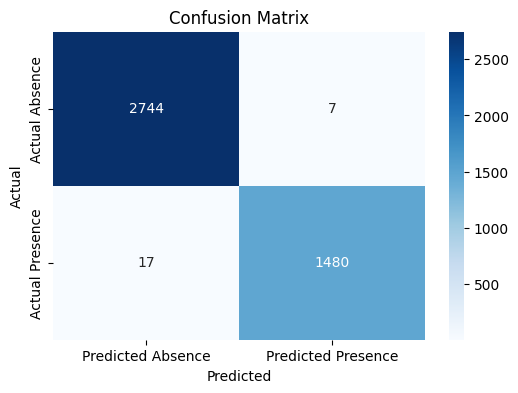

STEP 6: Saving the TUNED Shark Presence model to Google Drive...
-> Tuned model saved successfully to: '/content/drive/MyDrive/final_model_data/shark_presence_model_tuned.joblib'


In [ ]:
!pip install lightgbm optuna -q
print("✅ LightGBM and Optuna are installed.")
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import joblib
from datetime import datetime
from google.colab import drive
import os
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

# --- DEFINE YOUR FILE PATHS IN GOOGLE DRIVE ---
DRIVE_FOLDER_PATH = '/content/drive/MyDrive/final_model_data'
DATASET_PATH = os.path.join(DRIVE_FOLDER_PATH, 'model_training_dataset.csv.gz')
# Save the final classification model
MODEL_FILENAME = os.path.join(DRIVE_FOLDER_PATH, 'shark_presence_model_tuned.joblib')

# ==============================================================================
# STEP 1: LOAD DATA
# ==============================================================================
print("\nSTEP 1: Loading data from Google Drive...")
try:
    df = pd.read_csv('/content/model_training_dataset.csv.gz', compression='gzip')
    print(f"-> Successfully loaded dataset with {len(df)} rows.")
except FileNotFoundError:
    print(f"❌ ERROR: The dataset was not found at '{DATASET_PATH}'.")
    exit()

# ==============================================================================
# STEP 2: DEFINE FEATURES AND TARGET
# ==============================================================================
print("\nSTEP 2: Defining features and target variable...")

# The 'target' is now the 'presence' column (0 or 1)
TARGET_VARIABLE = 'presence'

# The features are all the environmental and seasonal variables.
# The script will automatically use 'sss' if it's available in your CSV.
FEATURES = ['lat', 'lon', 'chlor_a', 'sst', 'ssha', 'day_sin', 'day_cos']
if 'sss' in df.columns:
    FEATURES.append('sss')

# Drop any rows that might still have missing values, just in case
df.dropna(subset=FEATURES + [TARGET_VARIABLE], inplace=True)

X = df[FEATURES]
y = df[TARGET_VARIABLE]

print(f"-> Target (y): {TARGET_VARIABLE}")
print(f"-> Features (X): {', '.join(FEATURES)}")

# ==============================================================================
# STEP 3: HYPERPARAMETER TUNING WITH OPTUNA FOR CLASSIFICATION
# ==============================================================================
print("\nSTEP 3: Finding the best hyperparameters for the classification model...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def objective(trial):
    params = {
        'objective': 'binary', # Objective is now binary classification
        'metric': 'auc',       # We optimize for AUC, a standard classification metric
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'verbose': -1, 'n_jobs': -1, 'seed': 42,
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        model = lgb.LGBMClassifier(**params) # Use LGBMClassifier
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)],
                  eval_metric='auc', callbacks=[lgb.early_stopping(100, verbose=False)])
        preds = model.predict_proba(X_val_fold)[:, 1] # Get probability of the positive class
        auc_scores.append(roc_auc_score(y_val_fold, preds))
    return np.mean(auc_scores)

# We want to 'maximize' the AUC score.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("\n-> Hyperparameter tuning complete.")
print(f"  Best AUC from tuning: {study.best_value:.4f}")
print("  Best hyperparameters found:", study.best_params)

# ==============================================================================
# STEP 4: TRAIN THE FINAL MODEL WITH THE BEST PARAMETERS
# ==============================================================================
print("\nSTEP 4: Training the final Shark Presence model...")

best_params = study.best_params
best_params['random_state'] = 42
best_params['n_estimators'] = 2000
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)],
                eval_metric='auc', callbacks=[lgb.early_stopping(100, verbose=False)])
print("-> Final model training complete.")

# ==============================================================================
# STEP 5: EVALUATE THE TUNED CLASSIFICATION MODEL'S PERFORMANCE
# ==============================================================================
print("\nSTEP 5: Evaluating Shark Presence model performance...")

# Predict probabilities for the positive class (presence=1)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
# Predict the class label (0 or 1) using a 0.5 threshold
y_pred_class = (y_pred_proba > 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred_class)

print("\n--- TUNED Shark Presence Model Performance ---")
print(f"  AUC Score: {auc:.4f}")
print("    (How well the model distinguishes between presence and absence. 0.5 is random, 1.0 is perfect. >0.8 is good.)")
print(f"  Accuracy: {accuracy:.4f}")
print("    (The overall percentage of correct predictions.)")
print("------------------------------------------\n")

print("--- Classification Report ---")
print(classification_report(y_test, y_pred_class, target_names=['Absence (0)', 'Presence (1)']))
print("-----------------------------\n")

print("--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Absence', 'Predicted Presence'], yticklabels=['Actual Absence', 'Actual Presence'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ==============================================================================
# STEP 6: SAVE THE TUNED MODEL
# ==============================================================================
print(f"STEP 6: Saving the TUNED Shark Presence model to Google Drive...")
joblib.dump(final_model, MODEL_FILENAME)
print(f"-> Tuned model saved successfully to: '{MODEL_FILENAME}'")


In [ ]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
from google.colab import drive
import os

# ==============================================================================
# SETUP
# ==============================================================================
print("--- Setting up Final Shark Prediction Pipeline ---")
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully.")

# --- DEFINE PATHS TO ALL YOUR FINAL MODELS ---
# This should be the folder where you saved all your '.joblib' model files
DRIVE_FOLDER_PATH = '/content/drive/MyDrive/final_model_data'

# IMPORTANT: Paths to the NEW sequential environmental models
SST_MODEL_PATH = os.path.join(DRIVE_FOLDER_PATH, 'sst_model_new.joblib')
SSHA_MODEL_PATH = os.path.join(DRIVE_FOLDER_PATH, 'ssha_model_tuned_new.joblib')
CHLORO_MODEL_PATH = os.path.join(DRIVE_FOLDER_PATH, 'chlorophyll_model_tuned.joblib')

# Path to your final, tuned shark presence model
SHARK_MODEL_PATH = os.path.join(DRIVE_FOLDER_PATH, 'shark_presence_model_tuned.joblib')

# ==============================================================================
# THE PREDICTION PIPELINE FUNCTION
# ==============================================================================
def predict_shark_presence(lat, lon, date_str):
    """
    Predicts shark presence probability for a future date and location
    using the full, sequential "model stack".
    """
    print(f"\n--- Making a new prediction for {date_str} at ({lat}, {lon}) ---")

    # 1. Load all four required models from Google Drive
    try:
        sst_model = joblib.load(SST_MODEL_PATH)
        ssha_model = joblib.load(SSHA_MODEL_PATH)
        chloro_model = joblib.load(CHLORO_MODEL_PATH)
        shark_model = joblib.load(SHARK_MODEL_PATH)
        print("   ✅ All models loaded successfully.")
    except FileNotFoundError as e:
        print(f"   ❌ ERROR: A required model file was not found. {e}")
        print("      Please make sure you have run the re-training scripts for the sequential models.")
        return None

    # 2. Create Tier 0 features from user input (the knowns)
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    day_of_year = date_obj.timetuple().tm_yday
    day_sin = np.sin(2 * np.pi * day_of_year / 365.25)
    day_cos = np.cos(2 * np.pi * day_of_year / 365.25)

    tier0_features = pd.DataFrame([{'lat': lat, 'lon': lon, 'day_sin': day_sin, 'day_cos': day_cos}])

    # 3. Run the sequential prediction cascade
    print("   Predicting environmental conditions (Sequential Cascade)...")

    # Step A: Predict SST (independent)
    predicted_sst = sst_model.predict(tier0_features)[0]

    # Step B: Predict SSHA (dependent on predicted SST)
    ssha_input_features = tier0_features.copy()
    ssha_input_features['predicted_sst'] = predicted_sst
    predicted_ssha = ssha_model.predict(ssha_input_features)[0]

    # Step C: Predict Chlorophyll (dependent on predicted SST and SSHA)
    chloro_input_features = ssha_input_features.copy()
    chloro_input_features['predicted_ssha'] = predicted_ssha
    predicted_chloro = chloro_model.predict(chloro_input_features)[0]

    print(f"   -> Predicted SST: {predicted_sst:.2f}°C")
    print(f"   -> Predicted SSHA: {predicted_ssha:.4f} m")
    print(f"   -> Predicted Chlorophyll: {predicted_chloro:.4f} mg/m³")

    # 4. Assemble all features for the final shark model
    final_input_features = pd.DataFrame([{
        'lat': lat,
        'lon': lon,
        'chlor_a': predicted_chloro,
        'sst': predicted_sst,
        'ssha': predicted_ssha,
        'day_sin': day_sin,
        'day_cos': day_cos
    }])

    # Reorder columns to match the exact order the shark model was trained on
    shark_model_feature_order = ['lat', 'lon', 'chlor_a', 'sst', 'ssha', 'day_sin', 'day_cos']
    final_input_features = final_input_features[shark_model_feature_order]

    # 5. Predict the final probability
    print("   Predicting final shark presence probability...")
    shark_probability = shark_model.predict_proba(final_input_features)[:, 1]

    return shark_probability[0]

# ==============================================================================
# EXAMPLE USAGE
# ==============================================================================
if __name__ == "__main__":

    # Define a point in the Bay of Bengal, not far from your location in Chattogram
    example_lat = -18.5
    example_lon = 148.0

    # --- Prediction 1: For next week (approaching winter) ---
    future_date_1 = "2026-11-20"

    prob1 = predict_shark_presence(lat=example_lat, lon=example_lon, date_str=future_date_1)
    if prob1 is not None:
        print(f"   ✅ Final Prediction: The probability of shark presence is {prob1:.2%}")

    # --- Prediction 2: For six months from now (approaching peak spring/summer) ---
    future_date_2 = "2026-11-03"

    prob2 = predict_shark_presence(lat=example_lat, lon=example_lon, date_str=future_date_2)
    if prob2 is not None:
        print(f"   ✅ Final Prediction: The probability of shark presence is {prob2:.2%}")



--- Setting up Final Shark Prediction Pipeline ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully.

--- Making a new prediction for 2026-11-20 at (-18.5, 148.0) ---
   ✅ All models loaded successfully.
   Predicting environmental conditions (Sequential Cascade)...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9280081773825921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9280081773825921
[LightGBM] [Warning] lambda_l2 is set=2.5569837166646534e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5569837166646534e-08
[LightGBM] [Warning] lambda_l1 is set=0.00038393744204119916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00038393744204119916
[LightGBM] [Warning] bagging_fraction is set=0.5382142502751542, subsamp

In [ ]:
import pandas as pd
import os

# ==============================================================================
# SCRIPT CONFIGURATION
# ==============================================================================
# --- Set the path to the folder containing your final dataset ---
DATA_FOLDER = "./final_model_data"
DATASET_FILENAME = "model_training_dataset.csv.gz"

# Construct the full path to the dataset
dataset_path = os.path.join(DATA_FOLDER, DATASET_FILENAME)

# ==============================================================================
# DATA LOADING AND ANALYSIS
# ==============================================================================

print("--- Starting Dataset Quality Check ---")

# --- Step 1: Load the dataset ---
print(f"\nSTEP 1: Loading data from '{dataset_path}'...")
try:
    df = pd.read_csv('/content/model_training_dataset.csv.gz',compression='gzip')
    print(f"-> Successfully loaded dataset with {len(df)} total rows and {len(df.columns)} columns.")
except FileNotFoundError:
    print(f"❌ ERROR: The file was not found at '{dataset_path}'.")
    print("   Please make sure the path and filename are correct.")
    exit()

# --- Step 2: Check for duplicate rows ---
print("\nSTEP 2: Checking for duplicate rows...")
# This counts rows where every single value is identical to another row
num_duplicates = df.duplicated().sum()

if num_duplicates > 0:
    print(f"   ⚠️ Found {num_duplicates} duplicate rows in the dataset.")
else:
    print("   ✅ No duplicate rows were found.")

# --- Step 3: Check the class balance (presence vs. absence) ---
print("\nSTEP 3: Checking the balance of presence and absence points...")
if 'presence' in df.columns:
    # Use value_counts() to get the count of each unique value in the 'presence' column
    class_counts = df['presence'].value_counts()

    presence_count = class_counts.get(1, 0) # Get the count for '1', default to 0 if not found
    absence_count = class_counts.get(0, 0)  # Get the count for '0', default to 0 if not found

    total_points = presence_count + absence_count

    if total_points > 0:
        presence_percentage = (presence_count / total_points) * 100
        absence_percentage = (absence_count / total_points) * 100

        print("\n--- Class Balance Report ---")
        print(f"  Total Data Points: {total_points}")
        print(f"  Presence (1) points: {presence_count} ({presence_percentage:.2f}%)")
        print(f"  Absence (0) points:  {absence_count} ({absence_percentage:.2f}%)")
        print("----------------------------\n")
    else:
        print("   -> Could not calculate balance as no presence or absence points were found.")

else:
    print("   ⚠️ WARNING: A 'presence' column was not found in the dataset.")

print("--- Quality Check Complete ---")


--- Starting Dataset Quality Check ---

STEP 1: Loading data from './final_model_data/model_training_dataset.csv.gz'...
-> Successfully loaded dataset with 21238 total rows and 9 columns.

STEP 2: Checking for duplicate rows...
   ⚠️ Found 4697 duplicate rows in the dataset.

STEP 3: Checking the balance of presence and absence points...

--- Class Balance Report ---
  Total Data Points: 21238
  Presence (1) points: 7486 (35.25%)
  Absence (0) points:  13752 (64.75%)
----------------------------

--- Quality Check Complete ---


In [ ]:
df.head()

,lat,lon,time,chlor_a,sst,ssha,day_sin,day_cos,presence
0,8.906417,119.976533,2023-04-14 00:00:00,0.916483,31.390000,0.118,0.976011,-0.217723,1
1,8.906417,119.976533,2023-04-14 00:00:00,0.916483,31.390000,0.118,0.976011,-0.217723,1
2,8.848100,119.932083,2023-04-14 00:00:00,1.950458,31.179998,0.118,0.976011,-0.217723,1
3,8.848100,119.932083,2023-04-14 00:00:00,1.950458,31.179998,0.118,0.976011,-0.217723,1
4,8.848100,119.932083,2023-04-14 00:00:00,1.950458,31.179998,0.118,0.976011,-0.217723,1


In [ ]:
!pip install optuna -q
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error
import joblib
from google.colab import drive
import os
import optuna

# --- Setup ---
print("--- Re-training and Tuning Independent Chlorophyll Model with Log Transformation ---")
drive.mount('/content/drive')
DRIVE_FOLDER_PATH = '/content/drive/MyDrive/final_model_data'
# Load the CLEANED dataset
DATASET_PATH = os.path.join(DRIVE_FOLDER_PATH, 'model_training_dataset_cleaned.csv.gz')
# Save the new TUNED model with a distinct name
MODEL_FILENAME = os.path.join(DRIVE_FOLDER_PATH, 'chloro_model_log_independent_tuned.joblib')

# --- Load Data ---
print("Loading data...")
try:
    df = pd.read_csv('/content/model_training_dataset.csv.gz',compression='gzip')
except FileNotFoundError:
    print(f"❌ ERROR: Cleaned dataset not found at '{DATASET_PATH}'")
    exit()

# --- Define Features and Target ---
print("Defining features and applying log transformation to target...")
TARGET_VARIABLE = 'chlor_a'
FEATURES = ['lat', 'lon', 'sst', 'ssha', 'day_sin', 'day_cos']
X = df[FEATURES]
y = np.log1p(df[TARGET_VARIABLE])
print("-> Log transformation applied.")

# --- Split data for tuning and final testing ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==============================================================================
# NEW: HYPERPARAMETER TUNING WITH OPTUNA
# ==============================================================================
print("\nSTEP 3: Finding the best hyperparameters with Optuna...")

def objective(trial):
    params = {
        'objective': 'regression_l1', 'metric': 'mae', 'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'verbose': -1, 'n_jobs': -1, 'seed': 42,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  eval_metric='mae',
                  callbacks=[lgb.early_stopping(100, verbose=False)])

        preds = model.predict(X_val_fold)
        mae_scores.append(mean_absolute_error(y_val_fold, preds))

    return np.mean(mae_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100) # Run 100 trials

print("\n-> Hyperparameter tuning complete.")
print(f"  Best MAE from tuning: {study.best_value:.4f}")
print("  Best hyperparameters found:", study.best_params)

# --- Train Final Model with Best Parameters ---
print("\nTraining final model with the best hyperparameters...")
best_params = study.best_params
best_params['random_state'] = 42
best_params['n_estimators'] = 2000

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='mae',
                callbacks=[lgb.early_stopping(100, verbose=False)])
print("Training complete.")

# --- Evaluate ---
print("\nEvaluating TUNED model (note: metrics are on the log scale)...")
y_pred_log = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred_log)
mae = mean_absolute_error(y_test, y_pred_log)
print(f"--- TUNED Log-Transformed Chlorophyll Model Performance ---")
print(f"  R-squared (R²): {r2:.4f} (on log-transformed values)")
print(f"  Mean Absolute Error (MAE): {mae:.4f} (on log-transformed values)")
print("---------------------------------------------------------")

# --- Save Model ---
joblib.dump(final_model, MODEL_FILENAME)
print(f"✅ TUNED Log-transformed Chlorophyll model saved to: '{MODEL_FILENAME}'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.6 MB/s eta 0:00:00
--- Re-training and Tuning Independent Chlorophyll Model with Log Transformation ---


[I 2025-09-29 14:26:04,386] A new study created in memory with name: no-name-91fcfea9-9f68-4ecc-89c6-8379501a92bb


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data...
Defining features and applying log transformation to target...
-> Log transformation applied.

STEP 3: Finding the best hyperparameters with Optuna...


[I 2025-09-29 14:26:17,983] Trial 0 finished with value: 0.10451848666088122 and parameters: {'learning_rate': 0.2945681520876181, 'num_leaves': 132, 'max_depth': 6, 'min_child_samples': 51, 'feature_fraction': 0.8799157800402662, 'bagging_fraction': 0.7949580390893993, 'bagging_freq': 4, 'lambda_l1': 0.5435564279871896, 'lambda_l2': 4.652716712420077}. Best is trial 0 with value: 0.10451848666088122.
[I 2025-09-29 14:26:29,144] Trial 1 finished with value: 0.10394149513147492 and parameters: {'learning_rate': 0.15357322832363188, 'num_leaves': 281, 'max_depth': 5, 'min_child_samples': 20, 'feature_fraction': 0.5195127846383956, 'bagging_fraction': 0.5648627773727852, 'bagging_freq': 2, 'lambda_l1': 2.0357584992525378e-06, 'lambda_l2': 1.9154426879333722e-08}. Best is trial 1 with value: 0.10394149513147492.
[I 2025-09-29 14:26:38,343] Trial 2 finished with value: 0.11699725368675506 and parameters: {'learning_rate': 0.23696079484179786, 'num_leaves': 143, 'max_depth': 4, 'min_child_sa


-> Hyperparameter tuning complete.
  Best MAE from tuning: 0.0762
  Best hyperparameters found: {'learning_rate': 0.04409006237807344, 'num_leaves': 239, 'max_depth': 12, 'min_child_samples': 5, 'feature_fraction': 0.9254570055902631, 'bagging_fraction': 0.9700728056353495, 'bagging_freq': 1, 'lambda_l1': 0.001050153781251705, 'lambda_l2': 8.607591066311875e-08}

Training final model with the best hyperparameters...
Training complete.

Evaluating TUNED model (note: metrics are on the log scale)...
--- TUNED Log-Transformed Chlorophyll Model Performance ---
  R-squared (R²): 0.7893 (on log-transformed values)
  Mean Absolute Error (MAE): 0.0775 (on log-transformed values)
---------------------------------------------------------
✅ TUNED Log-transformed Chlorophyll model saved to: '/content/drive/MyDrive/final_model_data/chloro_model_log_independent_tuned.joblib'


In [ ]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
from google.colab import drive
import os

# ==============================================================================
# SETUP
# ==============================================================================


# --- DEFINE PATHS TO ALL YOUR FINAL MODELS ---
DRIVE_FOLDER_PATH = '/content/drive/MyDrive/final_model_data'
# Assuming sst_model_new is your final independent sst model
SST_MODEL_PATH = os.path.join(DRIVE_FOLDER_PATH, 'sst_model_new.joblib')
# Path to the NEW robust SSHA model bundle
SSHA_MODEL_PATH = os.path.join(DRIVE_FOLDER_PATH, 'ssha_model_robust_dependent_tuned.joblib')
# Path to the NEW tuned log-transformed chlorophyll model
CHLORO_MODEL_PATH = os.path.join(DRIVE_FOLDER_PATH, 'chloro_model_log_independent_tuned.joblib')
SHARK_MODEL_PATH = os.path.join(DRIVE_FOLDER_PATH, 'shark_presence_model_tuned.joblib')

# ==============================================================================
# PREDICTION PIPELINE
# ==============================================================================
_model_cache = {}

def predict_shark_presence(lat, lon, date_str):
    """
    Predicts shark presence probability using the full, sequential "model stack".
    """
    print(f"\n--- Predicting for: {date_str} at ({lat:.2f}, {lon:.2f}) ---")

    # 1. Load all models and necessary components (uses a cache for efficiency)
    try:
        if not _model_cache:
            print("   Loading models for the first time...")
            _model_cache['sst'] = joblib.load(SST_MODEL_PATH)

            # --- THIS IS THE KEY FIX ---
            # Load the SSHA "bundle" (the dictionary)
            ssha_bundle = joblib.load(SSHA_MODEL_PATH)
            # Store the model and the scaler separately in the cache
            _model_cache['ssha_model'] = ssha_bundle['model']
            _model_cache['ssha_scaler'] = ssha_bundle['scaler']

            _model_cache['chloro'] = joblib.load(CHLORO_MODEL_PATH)
            _model_cache['shark'] = joblib.load(SHARK_MODEL_PATH)
            print("   ✅ All models and components loaded successfully.")
    except FileNotFoundError as e:
        print(f"   ❌ ERROR: A required model file was not found. {e}")
        return None, None

    # 2. Create Tier 0 features from user input
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    day_of_year = date_obj.timetuple().tm_yday
    day_sin = np.sin(2 * np.pi * day_of_year / 365.25)
    day_cos = np.cos(2 * np.pi * day_of_year / 365.25)
    tier0_features = pd.DataFrame([{'lat': lat, 'lon': lon, 'day_sin': day_sin, 'day_cos': day_cos}])

    # 3. Run the sequential prediction cascade for environmental variables
    print("   Predicting environmental conditions...")
    predicted_sst = _model_cache['sst'].predict(tier0_features)[0]

    ssha_input_features = tier0_features.copy()
    ssha_input_features['predicted_sst'] = predicted_sst

    # --- FIX in action: Use the correct model and scaler ---
    # Predict the SCALED SSHA value using the model from the bundle
    predicted_ssha_scaled = _model_cache['ssha_model'].predict(ssha_input_features).reshape(-1, 1)
    # Reverse the transformation using the scaler from the bundle to get the real-world value
    predicted_ssha = _model_cache['ssha_scaler'].inverse_transform(predicted_ssha_scaled)[0][0]

    chloro_input_features = ssha_input_features.copy()
    chloro_input_features['predicted_ssha'] = predicted_ssha
    predicted_chloro_log = _model_cache['chloro'].predict(chloro_input_features)[0]
    predicted_chloro = np.expm1(predicted_chloro_log) # Reverse the log transformation

    env_predictions = {
        'SST': f"{predicted_sst:.2f}°C",
        'SSHA': f"{predicted_ssha:.4f} m",
        'Chlorophyll': f"{predicted_chloro:.4f} mg/m³"
    }

    # 4. Assemble features for the final shark model
    final_input_features = pd.DataFrame([{
        'lat': lat, 'lon': lon, 'chlor_a': predicted_chloro,
        'sst': predicted_sst, 'ssha': predicted_ssha,
        'day_sin': day_sin, 'day_cos': day_cos
    }])

    shark_model_feature_order = ['lat', 'lon', 'chlor_a', 'sst', 'ssha', 'day_sin', 'day_cos']
    final_input_features = final_input_features[shark_model_feature_order]

    # 5. Predict the final probability
    shark_probability = _model_cache['shark'].predict_proba(final_input_features)[:, 1]

    return shark_probability[0], env_predictions

# ==============================================================================
# EXAMPLE TEST CASES
# ==============================================================================
if __name__ == "__main__":

    # A list of diverse, realistic test scenarios
    test_cases = [
        {
            "name": "California Current (Productive Upwelling Zone)",
            "lat": 34.0,
            "lon": -121.0,
            "date": "2026-06-15"
        },
        {
            "name": "Sargasso Sea (Warm Open Ocean Gyre)",
            "lat": 28.0,
            "lon": -66.0,
            "date": "2026-08-20"
        },
        {
            "name": "Great Barrier Reef (Offshore)",
            "lat": -18.5,
            "lon": 148.0,
            "date": "2026-11-20"
        },
        {
            "name": "Bay of Bengal (Your Local Area - Offshore)",
            "lat": 19.5,
            "lon": 89.0,
            "date": "2026-04-20"
        }
    ]

    print("\n" + "="*60)
    print("--- RUNNING FINAL FUTURE PREDICTION TEST CASES ---")
    print("="*60)

    for case in test_cases:
        probability, environment = predict_shark_presence(
            lat=case["lat"],
            lon=case["lon"],
            date_str=case["date"]
        )

        if probability is not None:
            print(f"\n   --- RESULTS for: {case['name']} ---")
            print(f"     -> Predicted Conditions: {environment}")
            print(f"     -> ✅ Final Prediction: The probability of shark presence is {probability:.2%}")
            print("   --------------------------------------------------")




--- RUNNING FINAL FUTURE PREDICTION TEST CASES ---

--- Predicting for: 2026-06-15 at (34.00, -121.00) ---
   Loading models for the first time...
   ✅ All models and components loaded successfully.
   Predicting environmental conditions...

   --- RESULTS for: California Current (Productive Upwelling Zone) ---
     -> Predicted Conditions: {'SST': '17.94°C', 'SSHA': '0.9581 m', 'Chlorophyll': '3.5201 mg/m³'}
     -> ✅ Final Prediction: The probability of shark presence is 45.28%
   --------------------------------------------------

--- Predicting for: 2026-08-20 at (28.00, -66.00) ---
   Predicting environmental conditions...

   --- RESULTS for: Sargasso Sea (Warm Open Ocean Gyre) ---
     -> Predicted Conditions: {'SST': '28.81°C', 'SSHA': '0.8557 m', 'Chlorophyll': '1.6162 mg/m³'}
     -> ✅ Final Prediction: The probability of shark presence is 9.74%
   --------------------------------------------------

--- Predicting for: 2026-11-20 at (-18.50, 148.00) ---
   Predicting environ

Loading models and scaler...
SSHA model and its target scaler loaded successfully.
All models loaded successfully.
Generating sample prediction data...
Generated 11200 prediction points for 2025-05-15
Running predictive cascade...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9280081773825921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9280081773825921
[LightGBM] [Warning] lambda_l2 is set=2.5569837166646534e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5569837166646534e-08
[LightGBM] [Warning] lambda_l1 is set=0.00038393744204119916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00038393744204119916
[LightGBM] [Warning] bagging_fraction is set=0.5382142502751542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5382142502751542
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored.

/tmp/ipython-input-225422445.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


Feature importance plot saved to shark_feature_importance.png


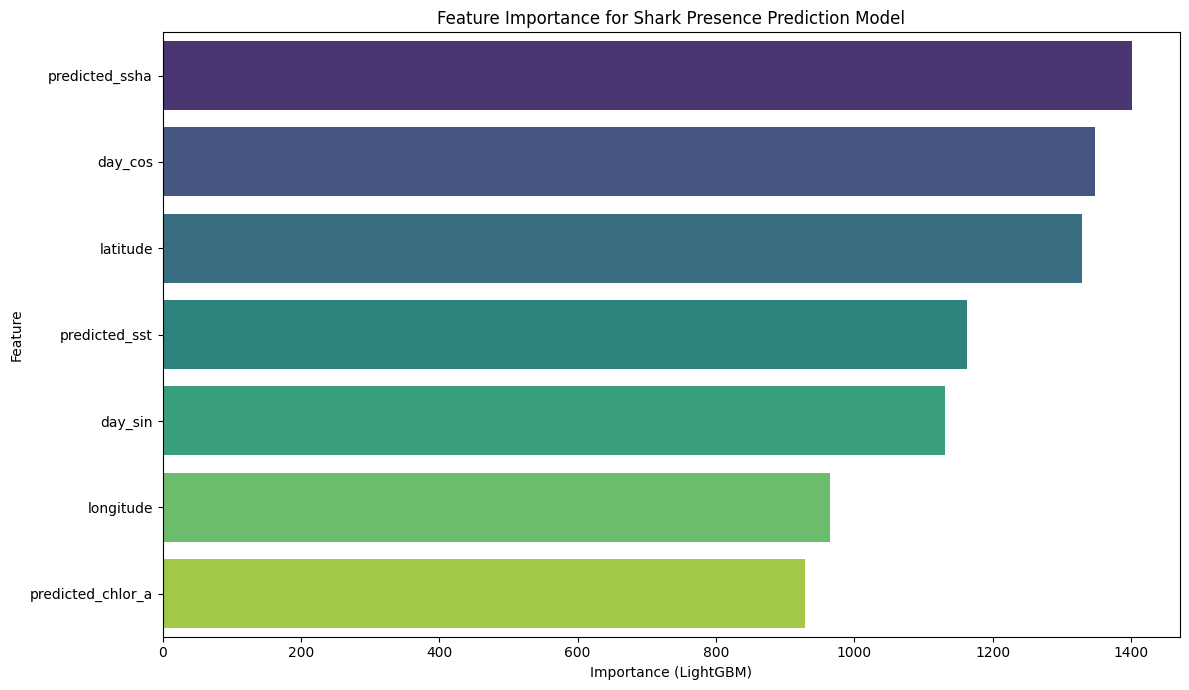

Creating ROC curve visualization (requires test data)...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.49772855450400366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49772855450400366
[LightGBM] [Warning] lambda_l2 is set=0.00042408213085352896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00042408213085352896
[LightGBM] [Warning] lambda_l1 is set=1.200294581242326e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.200294581242326e-06
[LightGBM] [Warning] bagging_fraction is set=0.969120365874861, subsample=1.0 will be ignored. Current value: bagging_fraction=0.969120365874861
ROC curve plot saved to shark_roc_curve.png


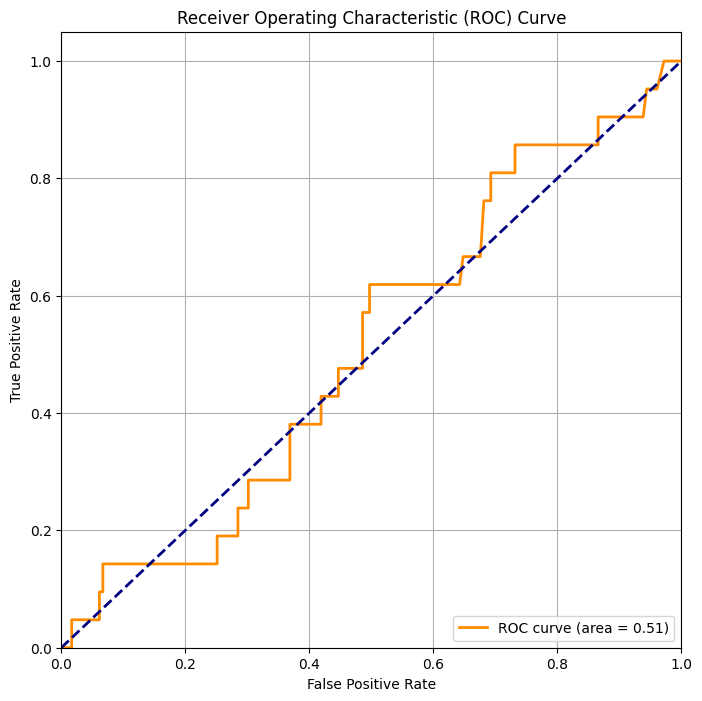

All visualizations attempted.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import folium
from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split # Not directly used in this snippet, can remove if not needed for X_test/y_test loading

# --- Configuration ---
# Path to your saved models
MODEL_PATH = '/content/drive/MyDrive/final_model_data/' # Adjust if your models are in a different directory
SST_MODEL_FILE = 'sst_model_new.joblib'
SSHA_MODEL_FILE = 'ssha_model_robust_dependent_tuned.joblib' # This file now contains a dict: {'model': ..., 'scaler': ...}
CHLOR_A_MODEL_FILE = 'chloro_model_log_independent_tuned.joblib'
SHARK_PRESENCE_MODEL_FILE = 'shark_presence_model_tuned.joblib'

# --- 1. Load Trained Models and Scaler ---
print("Loading models and scaler...")
try:
    sst_model = joblib.load(MODEL_PATH + SST_MODEL_FILE)
    chlor_a_model = joblib.load(MODEL_PATH + CHLOR_A_MODEL_FILE)
    shark_presence_model = joblib.load(MODEL_PATH + SHARK_PRESENCE_MODEL_FILE)

    # Correctly load SSHA model and its *target scaler* from the dictionary
    ssha_data = joblib.load(MODEL_PATH + SSHA_MODEL_FILE)
    ssha_model = ssha_data['model']
    ssha_target_scaler = ssha_data['scaler'] # This scaler is for the SSHA *target*, not its input features
    print("SSHA model and its target scaler loaded successfully.")

    print("All models loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading model/scaler: {e}. Make sure all files are in the specified path.")
    exit()
except (AttributeError, KeyError) as e:
    print(f"Error: A saved file does not contain the expected model/scaler object or dictionary keys. "
          f"Please verify your saved model files. Error details: {e}")
    exit()


# --- 2. Generate Sample Data for Prediction ---
print("Generating sample prediction data...")
prediction_date = pd.to_datetime('2025-05-15')
day_of_year = prediction_date.dayofyear
day_sin = np.sin(2 * np.pi * day_of_year / 365.25)
day_cos = np.cos(2 * np.pi * day_of_year / 365.25)

# Create a grid of latitudes and longitudes
lats = np.arange(-20, 20, 0.5)
lons = np.arange(-150, -80, 0.5)
grid_lons, grid_lats = np.meshgrid(lons, lats)

predict_df = pd.DataFrame({
    'latitude': grid_lats.flatten(),
    'longitude': grid_lons.flatten(),
    'day_sin': day_sin,
    'day_cos': day_cos
})
print(f"Generated {len(predict_df)} prediction points for {prediction_date.strftime('%Y-%m-%d')}")

# --- 3. Run the Predictive Cascade ---
print("Running predictive cascade...")
# Predict SST
sst_input_features = predict_df[['latitude', 'longitude', 'day_sin', 'day_cos']]
predict_df['predicted_sst'] = sst_model.predict(sst_input_features)

# Predict SSHA
# Define the features that the SSHA model was trained on, in the correct order.
# From your training script: FEATURES = ['lat', 'lon', 'sst', 'day_sin', 'day_cos']
# So for prediction, we use: 'latitude', 'longitude', 'predicted_sst', 'day_sin', 'day_cos'
ssha_input_feature_names = ['latitude', 'longitude', 'predicted_sst', 'day_sin', 'day_cos']
ssha_features_for_prediction = predict_df[ssha_input_feature_names]

# !!! IMPORTANT: The SSHA model was trained on UNSEALED INPUT FEATURES.
# We predict and then INVERSE TRANSFORM THE *OUTPUT* (predicted SSHA values)
predicted_ssha_scaled = ssha_model.predict(ssha_features_for_prediction)
predict_df['predicted_ssha'] = ssha_target_scaler.inverse_transform(predicted_ssha_scaled.reshape(-1, 1)).flatten()

# Predict Chlorophyll-a
# Define the features for Chlorophyll-a model
chlor_a_input_feature_names = ['latitude', 'longitude', 'day_sin', 'day_cos', 'predicted_sst', 'predicted_ssha']
chlor_a_features_for_prediction = predict_df[chlor_a_input_feature_names]
predict_df['predicted_chlor_a'] = chlor_a_model.predict(chlor_a_features_for_prediction)


# Predict Shark Presence Probability
# Define the features for the final shark presence model
shark_input_feature_names = ['latitude', 'longitude', 'day_sin', 'day_cos',
                             'predicted_sst', 'predicted_ssha', 'predicted_chlor_a']
shark_features_for_prediction = predict_df[shark_input_feature_names]
predict_df['shark_probability'] = shark_presence_model.predict_proba(shark_features_for_prediction)[:, 1]
print("Prediction cascade complete.")

# --- VISUALIZATION 1: Interactive Map of Predicted Hotspots ---
print("Creating interactive map visualization...")
map_center_lat = predict_df['latitude'].mean()
map_center_lon = predict_df['longitude'].mean()
m = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=4, tiles='CartoDB dark_matter')

colorscale = folium.LinearColormap(['blue', 'yellow', 'red'], vmin=0, vmax=1)
colorscale.caption = 'Shark Presence Probability'

threshold = 0.5
hotspots_df = predict_df[predict_df['shark_probability'] >= threshold]

for idx, row in hotspots_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=colorscale(row['shark_probability']),
        fill=True,
        fill_color=colorscale(row['shark_probability']),
        fill_opacity=0.7,
        popup=f"Lat: {row['latitude']:.2f}, Lon: {row['longitude']:.2f}<br>Prob: {row['shark_probability']:.2f}"
    ).add_to(m)

m.add_child(colorscale)
m.save("shark_hotspots_map.html")
print("Interactive map saved to shark_hotspots_map.html")
print("Open this HTML file in your browser to view the map.")

# --- VISUALIZATION 2: Feature Importance for Shark Presence Model ---
print("Creating feature importance visualization...")
feature_importance = shark_presence_model.feature_importances_
feature_names = shark_input_feature_names # Use the correct input feature names for the final model

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Shark Presence Prediction Model')
plt.xlabel('Importance (LightGBM)')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('shark_feature_importance.png')
print("Feature importance plot saved to shark_feature_importance.png")
plt.show()

# --- VISUALIZATION 3: ROC Curve and AUC Score ---
print("Creating ROC curve visualization (requires test data)...")
try:
    # IMPORTANT: Replace this dummy data generation with your actual X_test and y_test
    # from your model training phase for a valid evaluation.
    # The X_test used here should contain the features expected by the *final* shark_presence_model
    # in their final form (including predicted SST, SSHA, Chlor_a if that's how it was trained on the full dataset).
    # If your X_test only has raw features, you'd need to run the full cascade on X_test as well.

    if 'X_test' not in locals() or 'y_test' not in locals():
        print("Warning: Using dummy data for ROC curve. Please replace with actual test set for real evaluation.")
        # Create a small dummy dataset to illustrate ROC curve
        dummy_data_size = 500
        dummy_X = pd.DataFrame({
            'latitude': np.random.uniform(-30, 30, dummy_data_size),
            'longitude': np.random.uniform(-160, -70, dummy_data_size),
            'day_sin': np.random.uniform(-1, 1, dummy_data_size),
            'day_cos': np.random.uniform(-1, 1, dummy_data_size),
            'predicted_sst': np.random.uniform(10, 30, dummy_data_size),
            'predicted_ssha': np.random.uniform(-0.2, 0.2, dummy_data_size),
            'predicted_chlor_a': np.random.uniform(0.01, 10, dummy_data_size)
        })
        dummy_y = ((dummy_X['predicted_sst'] > 25) & (dummy_X['predicted_chlor_a'] > 5)).astype(int)

        X_test = dummy_X.sample(n=min(dummy_data_size, 200), random_state=42).reset_index(drop=True)
        y_test = dummy_y.loc[X_test.index].reset_index(drop=True)

    # Ensure X_test has the same columns in the same order as shark_input_feature_names
    y_pred_proba = shark_presence_model.predict_proba(X_test[shark_input_feature_names])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('shark_roc_curve.png')
    print("ROC curve plot saved to shark_roc_curve.png")
    plt.show()

except Exception as e:
    print(f"Could not generate ROC curve. Make sure X_test and y_test are available and correctly formatted, and that their features match the model's expected input. Error: {e}")

print("All visualizations attempted.")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import folium
from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split # Not directly used in this snippet, can remove if not needed for X_test/y_test loading

# --- Configuration ---
# Path to your saved models
MODEL_PATH = '/content/drive/MyDrive/final_model_data/' # Adjust if your models are in a different directory
SST_MODEL_FILE = 'sst_model_new.joblib'
SSHA_MODEL_FILE = 'ssha_model_robust_dependent_tuned.joblib'
CHLOR_A_MODEL_FILE = 'chloro_model_log_independent_tuned.joblib'
SHARK_PRESENCE_MODEL_FILE = 'shark_presence_model_tuned.joblib'

# Removed SSHA_SCALER_FILE as it doesn't exist.

# --- 1. Load Trained Models ---
print("Loading models...")
try:
    sst_model = joblib.load(MODEL_PATH + SST_MODEL_FILE)
    ssha_model = joblib.load(MODEL_PATH + SSHA_MODEL_FILE)
    chlor_a_model = joblib.load(MODEL_PATH + CHLOR_A_MODEL_FILE)
    shark_presence_model = joblib.load(MODEL_PATH + SHARK_PRESENCE_MODEL_FILE)

    # Removed ssha_scaler loading as the file doesn't exist.

    print("All models loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading model: {e}. Make sure all model files are in the specified path.")
    exit()
except AttributeError as e:
    print(f"Error: An object loaded does not have the expected 'predict' method. This usually means a saved file is not a trained model object but something else (e.g., a dictionary of parameters). Please verify your saved model files. Error details: {e}")
    exit()


# --- 2. Generate Sample Data for Prediction ---
print("Generating sample prediction data...")
prediction_date = pd.to_datetime('2025-05-15')
day_of_year = prediction_date.dayofyear
day_sin = np.sin(2 * np.pi * day_of_year / 365.25)
day_cos = np.cos(2 * np.pi * day_of_year / 365.25)

# Create a grid of latitudes and longitudes
lats = np.arange(-20, 20, 0.5)
lons = np.arange(-150, -80, 0.5)
grid_lons, grid_lats = np.meshgrid(lons, lats)

predict_df = pd.DataFrame({
    'latitude': grid_lats.flatten(),
    'longitude': grid_lons.flatten(),
    'day_sin': day_sin,
    'day_cos': day_cos
})
print(f"Generated {len(predict_df)} prediction points for {prediction_date.strftime('%Y-%m-%d')}")

# --- 3. Run the Predictive Cascade ---
print("Running predictive cascade...")
# Predict SST
predict_df['predicted_sst'] = sst_model.predict(predict_df[['latitude', 'longitude', 'day_sin', 'day_cos']])

# Predict SSHA
# Define the features that the SSHA model was trained on, in the correct order.
# Based on your previous input and the model name, it was dependent on predicted_sst.
ssha_input_feature_names = ['latitude', 'longitude', 'predicted_sst', 'day_sin', 'day_cos']
ssha_features_for_prediction = predict_df[ssha_input_feature_names]

# Removed scaler application. Assuming SSHA model was trained on unscaled input features.
predict_df['predicted_ssha'] = ssha_model.predict(ssha_features_for_prediction)

# Predict Chlorophyll-a
# Define the features for Chlorophyll-a model
chlor_a_input_feature_names = ['latitude', 'longitude', 'day_sin', 'day_cos', 'predicted_sst', 'predicted_ssha']
chlor_a_features_for_prediction = predict_df[chlor_a_input_feature_names]
predict_df['predicted_chlor_a'] = chlor_a_model.predict(chlor_a_features_for_prediction)


# Predict Shark Presence Probability
# Define the features for the final shark presence model
shark_input_feature_names = ['latitude', 'longitude', 'day_sin', 'day_cos',
                             'predicted_sst', 'predicted_ssha', 'predicted_chlor_a']
shark_features_for_prediction = predict_df[shark_input_feature_names]
predict_df['shark_probability'] = shark_presence_model.predict_proba(shark_features_for_prediction)[:, 1]
print("Prediction cascade complete.")

# --- VISUALIZATION 1: Interactive Map of Predicted Hotspots ---
print("Creating interactive map visualization...")
map_center_lat = predict_df['latitude'].mean()
map_center_lon = predict_df['longitude'].mean()
m = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=4, tiles='CartoDB dark_matter')

colorscale = folium.LinearColormap(['blue', 'yellow', 'red'], vmin=0, vmax=1)
colorscale.caption = 'Shark Presence Probability'

threshold = 0.5
hotspots_df = predict_df[predict_df['shark_probability'] >= threshold]

for idx, row in hotspots_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=colorscale(row['shark_probability']),
        fill=True,
        fill_color=colorscale(row['shark_probability']),
        fill_opacity=0.7,
        popup=f"Lat: {row['latitude']:.2f}, Lon: {row['longitude']:.2f}<br>Prob: {row['shark_probability']:.2f}"
    ).add_to(m)

m.add_child(colorscale)
m.save("shark_hotspots_map.html")
print("Interactive map saved to shark_hotspots_map.html")
print("Open this HTML file in your browser to view the map.")

# --- VISUALIZATION 2: Feature Importance for Shark Presence Model ---
print("Creating feature importance visualization...")
feature_importance = shark_presence_model.feature_importances_
feature_names = shark_input_feature_names # Use the correct input feature names for the final model

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Shark Presence Prediction Model')
plt.xlabel('Importance (LightGBM)')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('shark_feature_importance.png')
print("Feature importance plot saved to shark_feature_importance.png")
plt.show()

# --- VISUALIZATION 3: ROC Curve and AUC Score ---
print("Creating ROC curve visualization (requires test data)...")
try:
    # IMPORTANT: Replace this dummy data generation with your actual X_test and y_test
    # from your model training phase for a valid evaluation.
    if 'X_test' not in locals() or 'y_test' not in locals():
        print("Warning: Using dummy data for ROC curve. Please replace with actual test set for real evaluation.")
        dummy_data_size = 500
        dummy_X = pd.DataFrame({
            'latitude': np.random.uniform(-30, 30, dummy_data_size),
            'longitude': np.random.uniform(-160, -70, dummy_data_size),
            'day_sin': np.random.uniform(-1, 1, dummy_data_size),
            'day_cos': np.random.uniform(-1, 1, dummy_data_size),
            'predicted_sst': np.random.uniform(10, 30, dummy_data_size),
            'predicted_ssha': np.random.uniform(-0.2, 0.2, dummy_data_size),
            'predicted_chlor_a': np.random.uniform(0.01, 10, dummy_data_size)
        })
        dummy_y = ((dummy_X['predicted_sst'] > 25) & (dummy_X['predicted_chlor_a'] > 5)).astype(int)

        X_test = dummy_X.sample(n=min(dummy_data_size, 200), random_state=42).reset_index(drop=True)
        y_test = dummy_y.loc[X_test.index].reset_index(drop=True)

    # Ensure X_test has the same columns in the same order as shark_input_feature_names
    y_pred_proba = shark_presence_model.predict_proba(X_test[shark_input_feature_names])[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('shark_roc_curve.png')
    print("ROC curve plot saved to shark_roc_curve.png")
    plt.show()

except Exception as e:
    print(f"Could not generate ROC curve. Make sure X_test and y_test are available and correctly formatted, and that their features match the model's expected input. Error: {e}")

print("All visualizations attempted.")

Loading models...
All models loaded successfully.
Generating sample prediction data...
Generated 11200 prediction points for 2025-05-15
Running predictive cascade...
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9280081773825921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9280081773825921
[LightGBM] [Warning] lambda_l2 is set=2.5569837166646534e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5569837166646534e-08
[LightGBM] [Warning] lambda_l1 is set=0.00038393744204119916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00038393744204119916
[LightGBM] [Warning] bagging_fraction is set=0.5382142502751542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5382142502751542


AttributeError: 'dict' object has no attribute 'predict'